# Atividade 03 - Parte 01
Nesta atividade o tópicos realizados foram:

1- Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas;

2- Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade;

3- Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs. Deve ser considerado o efeito Tip-Downwash;

4- Implementar a função do modelo gaussiano;

5- Realizar simulações com o script criado, utilizando diferentes classes de estabilidade, velocidades do vento, alturas de chaminé. Considere a taxa de emissão que você estimou na primeira atividade. Encontre a altura de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491;

6- Plotagem e discussão dos resultados.

## 1- Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas

Utilizando os dados do EZ-AERMOD de 5 dias do verão e 5 duias do inverno e determinando sua classe com base na Classificação de Estabilidade de Pasquill.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados
data = pd.read_csv('C:\\Users\\Dell\\OneDrive\\Documentos\\GitHub\\Polatm_RamonVieira\\inputs\\EZ_AERMOD_RamonVieira_2024-06-04\\METEO.csv')

# Ajustar o ano de dois dígitos para quatro dígitos
data['year'] = data['year'].apply(lambda x: 2000 + x if x < 100 else x)

# Criar a coluna datetime
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

# Configurar o índice datetime
data.set_index('datetime', inplace=True)

# Selecionar 5 dias de verão e 5 dias de inverno
verao = data[(data.index.month >= 12) | (data.index.month <= 2)].sample(n=5, random_state=1)
inverno = data[(data.index.month >= 6) & (data.index.month <= 8)].sample(n=5, random_state=1)

# Concatenar os dias selecionados
selecionados = pd.concat([verao, inverno])

# Calcular a média horária dos parâmetros numéricos
medias_diarias = selecionados.groupby(selecionados.index.date).mean()

# Função para determinar a classe de estabilidade
def determinar_classe_estabilidade(row):
    cobertura_nuvens = row['cloud cover (tenths)']
    velocidade_vento = row['wind speed (m/s)']
    fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
    
    if fluxo_calor_sensivel > 10:
        insolacao = 'forte'
    elif 3 < fluxo_calor_sensivel <= 10:
        insolacao = 'moderada'
    else:
        insolacao = 'fraca'

    if cobertura_nuvens < 3:
        if velocidade_vento < 2:
            return 'A' if insolacao == 'forte' else 'B'
        elif 2 <= velocidade_vento < 3:
            return 'B' if insolacao == 'forte' else 'C'
        else:
            return 'C'
    elif 3 <= cobertura_nuvens < 7:
        if velocidade_vento < 2:
            return 'B' if insolacao == 'forte' else 'C'
        elif 2 <= velocidade_vento < 5:
            return 'C'
        else:
            return 'D'
    else:
        if velocidade_vento < 2:
            return 'C'
        elif 2 <= velocidade_vento < 5:
            return 'D'
        else:
            return 'E'

# Aplicar a função para cada linha
medias_diarias['classe_estabilidade'] = medias_diarias.apply(determinar_classe_estabilidade, axis=1)

# Exibir os resultados
print(medias_diarias[['cloud cover (tenths)', 'wind speed (m/s)', 'sensible heat flux (W/m2)', 'classe_estabilidade']])

            cloud cover (tenths)  wind speed (m/s)  sensible heat flux (W/m2)  \
2023-02-14                   3.0               6.2                       35.3   
2023-02-28                   6.0               5.7                      -44.9   
2023-06-07                   3.0               3.6                      -31.2   
2023-06-14                   8.0               5.7                      -45.9   
2023-07-01                   6.0               2.1                       -8.1   
2023-08-13                   6.0               7.2                      -64.0   
2023-08-18                   1.0               8.2                      -64.0   
2023-12-01                   8.0               1.0                       44.9   
2023-12-07                   8.0               4.6                      -36.9   
2023-12-13                   6.0               3.6                      -32.0   

           classe_estabilidade  
2023-02-14                   D  
2023-02-28                   D  
2023-06-0

## 2- Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade

Passando a tabela de Parâmetros de Dispersão em Ambientes Rurais e Urbanos para o Jupyter.

In [144]:
def sigmaYZ(x, classe, urbOrRural):
    if urbOrRural == 'urbano':
        if classe == 'A' or classe == 'B':
            sigmaY = 0.32 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.24 * x * (1 + 0.001 * x) ** 0.5
        elif classe == 'C':
            sigmaY = 0.22 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'D':
            sigmaY = 0.16 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.14 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E' or classe == 'F':
            sigmaY = 0.11 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        else:
            raise ValueError('Classe de estabilidade errada')
    elif urbOrRural == 'rural':
        if classe == 'A':
            sigmaY = 0.22 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'B':
            sigmaY = 0.16 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.12 * x
        elif classe == 'C':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0002 * x) ** (-0.5)
        elif classe == 'D':
            sigmaY = 0.08 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.06 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.06 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.03 * x * (1 + 0.0003 * x) ** (-1)
        elif classe == 'F':
            sigmaY = 0.04 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.016 * x * (1 + 0.0003 * x) ** (-1)
        else:
            raise ValueError('Classe de estabilidade errada')
    else:
        raise ValueError('Tipo de ambiente deve ser "urbano" ou "rural"')
    
    return sigmaY, sigmaZ

## 3- Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs. Deve ser considerado o efeito Tip-Downwash

### Davidson-Bryant

def sobrelevacaoDavidsonBryant(d, Vs, u, deltaT, Ts):
    """
    Calcula a sobrelevação da pluma usando a fórmula de Davidson-Bryant.
    """
    delta_h = d * (Vs / u) ** 1.4 * (1 + deltaT / Ts)
    return delta_h

### Holland

def sobrelevacaoHolland(Vs, d, u, p, deltaT, Ts):
    """
    Calcula a sobrelevação da pluma usando a fórmula empírica de Holland (1953).
    """
    delta_h_max = (Vs * d / u) * (1.5 + 2.68e-3 * p * (deltaT / Ts) * d)
    return delta_h_max

### Briggs

In [148]:
def sobrelevacaoBriggs(Fb, Vs, d, u, deltaT, Ts, He, classe):
    """
    Calcula a sobrelevação da pluma usando o modelo de Briggs adaptado para diferentes tipos de atmosfera.
    """
    # Determinar se a atmosfera é instável ou estável com base na classe de Pasquill
    tipo_atmosfera = 'instavel' if classe in ['A', 'B', 'C', 'D'] else 'estavel'
    
    # Calcular (ΔT)e com base no tipo de atmosfera
    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            deltaTe = 0.0297 * Ts * ((Vs ** (1/3)) / (d ** (2/3)))
        else:
            deltaTe = 0.00575 * Ts * ((Vs ** (2/3)) / (d ** (1/3)))
    else:
        deltaTe = 0.01958 * Ts * ((Vs ** 0.5) * (Fb ** 0.5))

    # Calcular H com base nas condições fornecidas
    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            if deltaT < deltaTe:
                H = He + 3 * d * (Vs / u)
            else:
                H = He + 21.425 * (Fb ** (3/4) / (u ** (1/2)))
        else:
            if deltaT < deltaTe:
                H = He + 3 * d * (Vs / u)
            else:
                H = He + 2.6 * ((Fb ** (1/3)) / (u ** (1/3)))
    else:
        if deltaT < deltaTe:
            H = He + 1.5 * ((Fb ** (1/3)) / (u ** (1/3)))
        else:
            H = He + 2.6 * ((Fb ** (1/3)) / (u ** (1/3)))

    return H - He

## 4- Implementar a função do modelo gaussiano

In [146]:
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc

## Teste com dados de exemplo

A primeira simulação está com dados fictícios para avaliar a funcionalidade do código.
Importante salientar que, apesar do presente código contar com os métodos de Davidson-Bryant, Holland e Briggs, o método utizado na simulação de exemplo e nas demais que virão a seguir será o de Briggs.


Resultados Simulação
Classe de Estabilidade: C


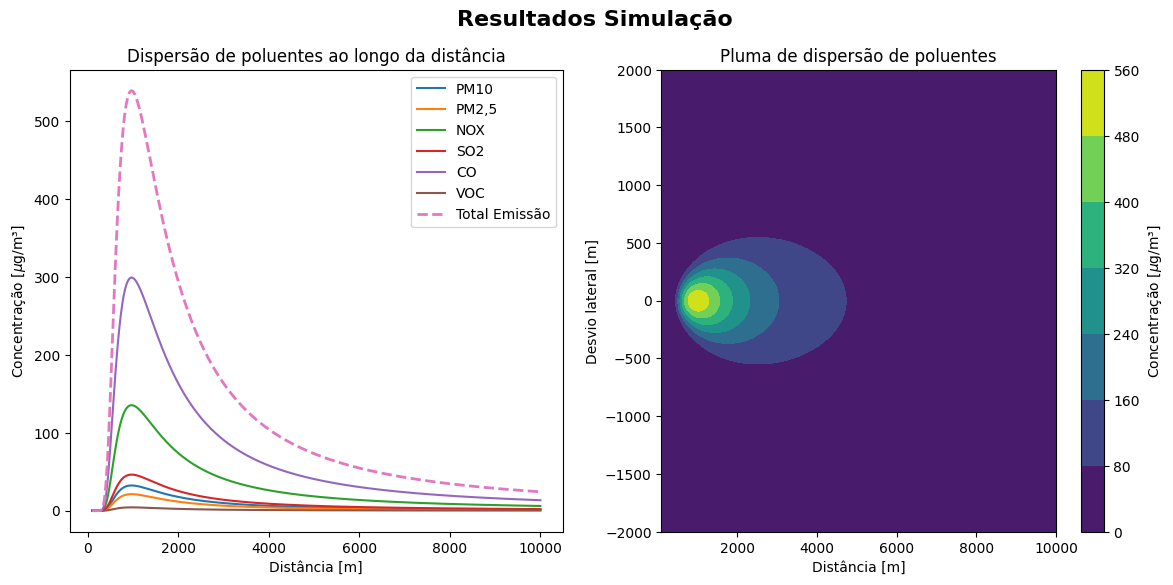

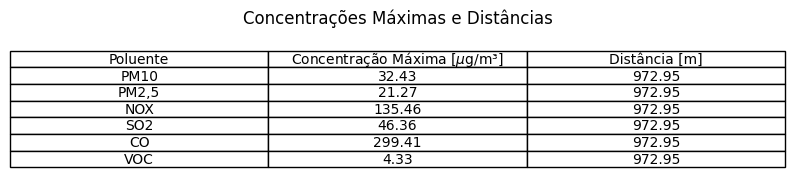

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros de entrada para a simulação
params = {
    'u': 5,  # m/s
    'y': 0,  # estimando na direção do vento
    'z': 1.5,  # altura do nariz
    'H': 250,  # m
    'urbOrRural': 'urbano',
    'd': 3.5,  # Diâmetro da chaminé
    'Vs': 20,  # Velocidade de saída do gás
    'p': 1013,  # Pressão atmosférica em hPa
    'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,  # Temperatura de saída da pluma
    'Fb': 1000,  # Fluxo de empuxo da pluma
    'x': np.linspace(100, 10000, 500)  # Distância
}

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['wind speed (m/s)']
fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
cobertura_nuvens = row['cloud cover (tenths)']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
#sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
#deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
#H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], params['H'], classe)
H_eff = params['H'] + deltaH

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

## Utilizando os dados obtidos nas atividades anteriores

Tomando como base a taxa de emissão calculada no trabalho 1, será simulado uma série alturas de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491.

## O primeiro teste

Condição de atmosfera instável, com classificação de Pasquill E. Altura de chaminé 250 m para a simulação 2 e 100 m para a simulação 1.


Resultados Simulação 1
Classe de Estabilidade: C


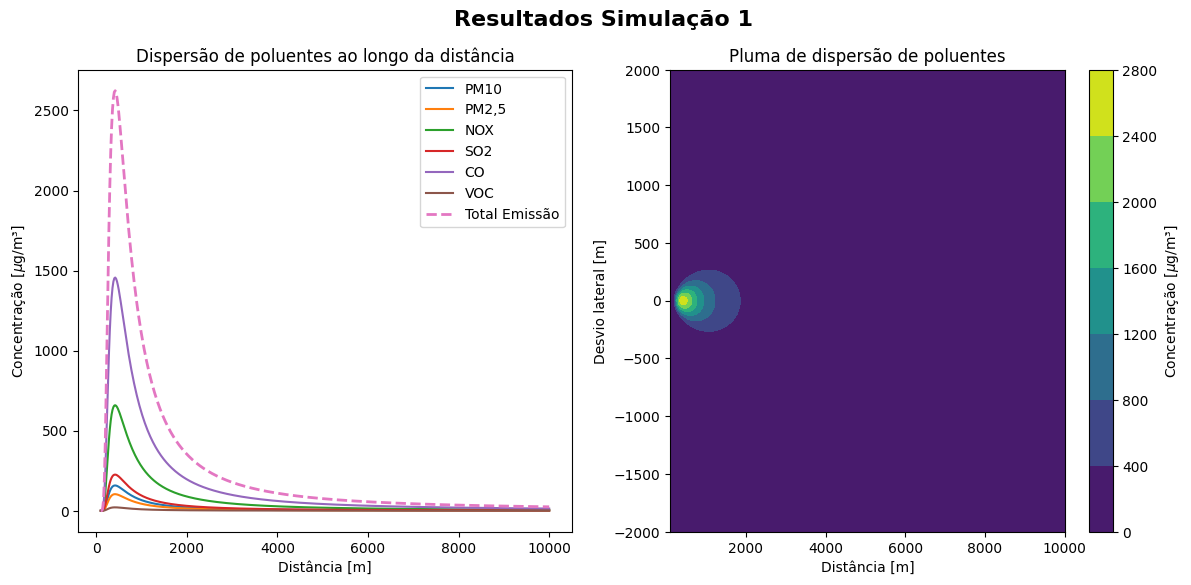

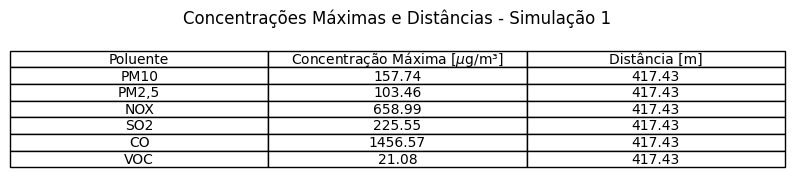


Resultados Simulação 2
Classe de Estabilidade: C


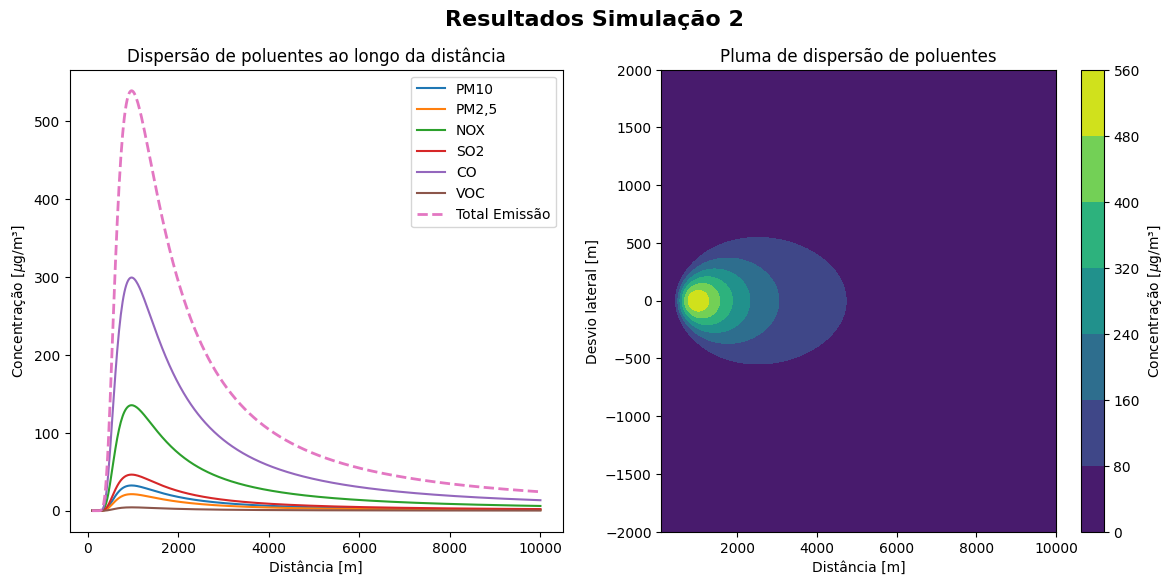

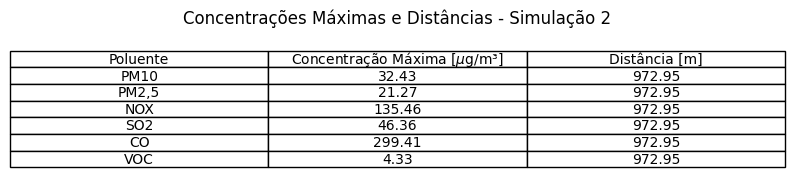

In [151]:
# Parâmetros de entrada para as duas simulações
simulacoes = [
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 100,  # m
        'urbOrRural': 'urbano',
        'd': 3.5,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    },
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 250,  # m
        'urbOrRural': 'urbano',
        'd': 3.0,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    }
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação para cada conjunto de parâmetros
for idx, params in enumerate(simulacoes):
    row = medias_diarias.sample(1).iloc[0]
    classe = row['classe_estabilidade']
    velocidade_vento = row['wind speed (m/s)']
    fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
    cobertura_nuvens = row['cloud cover (tenths)']
    
    print(f"\n{'='*40}\nResultados Simulação {idx+1}\n{'='*40}")
    print(f"Classe de Estabilidade: {classe}")
    
    sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
    deltaH = sobrelevacaoBriggs(params['Fb'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], params['H'], classe)
    H_eff = params['H'] + deltaH
    
    # Criar figura e eixos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Resultados Simulação {idx+1}', fontsize=16, fontweight='bold')
    
    # Inicializar lista para armazenar os dados de concentração máxima
    max_concentrations = []

    # Plotar gráfico de linha para cada poluente e a somatória
    for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
        qs = valor  # Usar o valor do poluente atual
        conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
        ax1.plot(params['x'], conc, label=f'{poluente}')
        
        # Encontrar concentração máxima e distância
        max_conc = np.max(conc)
        max_dist = params['x'][np.argmax(conc)]
        max_concentrations.append((poluente, max_conc, max_dist))

    # Plotar a somatória das emissões
    total_qs = poluentes_df['total_qs'].iloc[0]
    conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)
    
    ax1.set_xlabel('Distância [m]')
    ax1.set_ylabel('Concentração [$\mu$g/m³]')
    ax1.set_title('Dispersão de poluentes ao longo da distância')
    ax1.legend()
    
    # Gráfico de contorno para a somatória das emissões
    X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
    sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
    conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)
    
    contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
    fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
    ax2.set_xlabel('Distância [m]')
    ax2.set_ylabel('Desvio lateral [m]')
    ax2.set_title('Pluma de dispersão de poluentes')
    
    plt.show()
    
    # Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
    max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
    max_conc_df = max_conc_df.round(2)
    
    # Plotar a tabela de concentrações máximas
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
    plt.title(f'Concentrações Máximas e Distâncias - Simulação {idx+1}')
    plt.show()


## O segundo teste

Mesmas alturas de chaminé a condição atmosférica estável para Simulação 1 e instável para simulação 2, com classifcação de Pasquill C e E respectivamente.


Resultados Simulação 1
Classe de Estabilidade: C


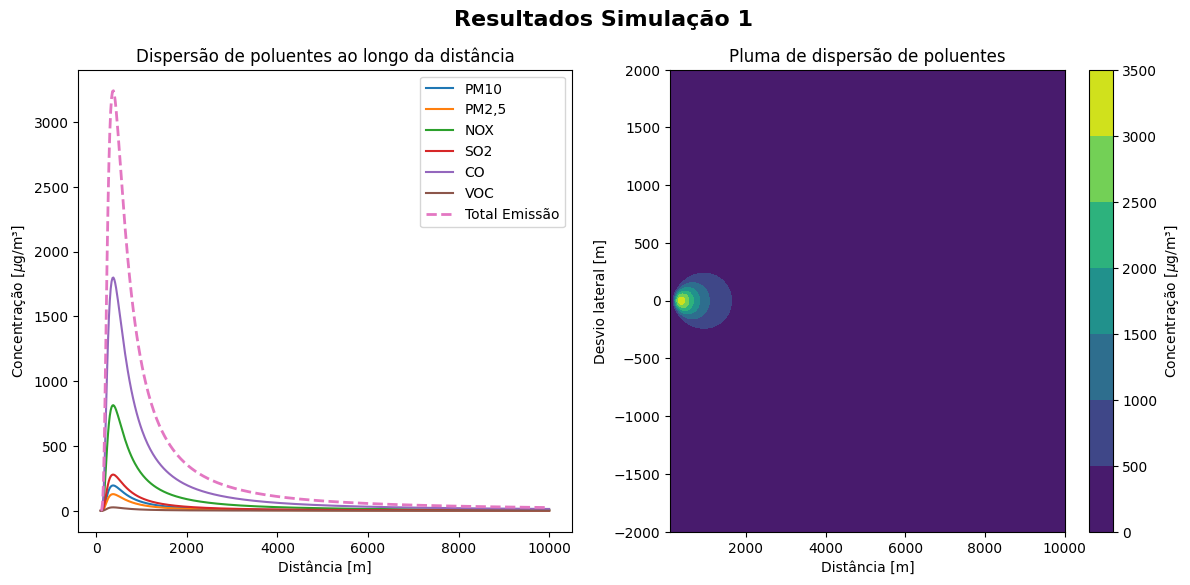

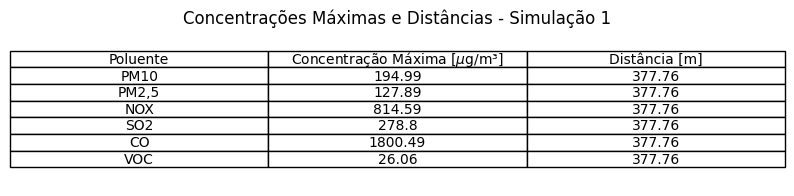


Resultados Simulação 2
Classe de Estabilidade: E


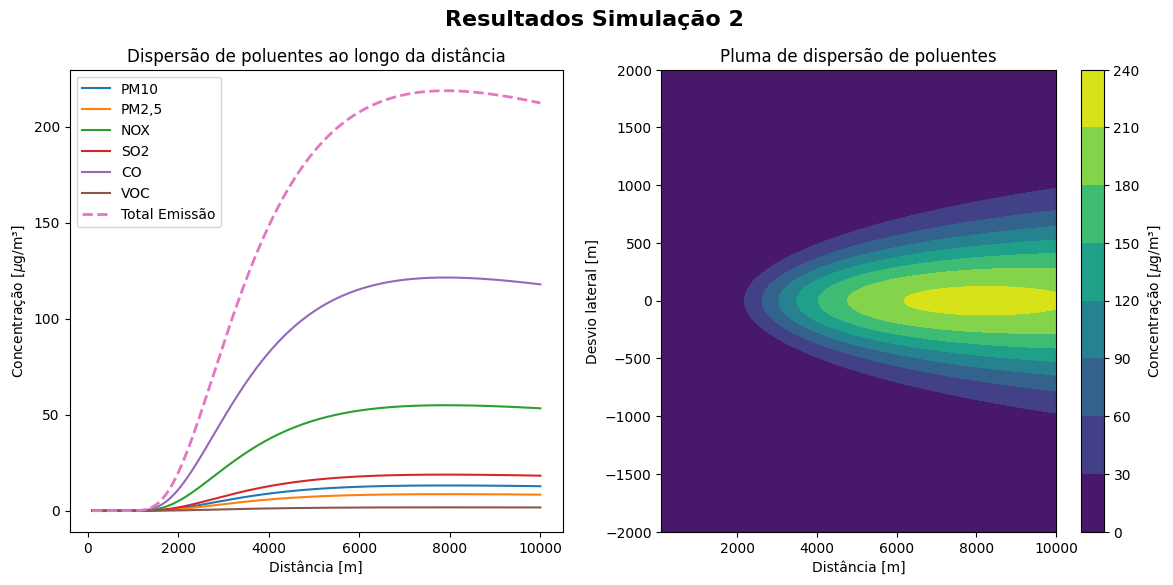

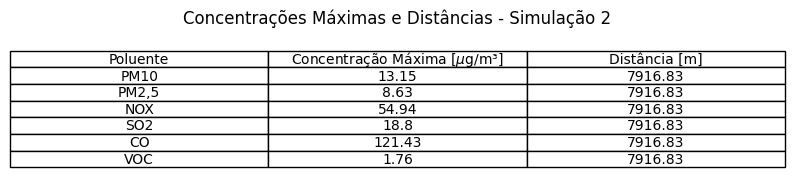

In [70]:
# Parâmetros de entrada para as duas simulações
simulacoes = [
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 100,  # m
        'urbOrRural': 'urbano',
        'd': 3.5,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    },
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 250,  # m
        'urbOrRural': 'urbano',
        'd': 3.0,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    }
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação para cada conjunto de parâmetros
for idx, params in enumerate(simulacoes):
    row = medias_diarias.sample(1).iloc[0]
    classe = row['classe_estabilidade']
    velocidade_vento = row['wind speed (m/s)']
    fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
    cobertura_nuvens = row['cloud cover (tenths)']
    
    print(f"\n{'='*40}\nResultados Simulação {idx+1}\n{'='*40}")
    print(f"Classe de Estabilidade: {classe}")
    
    sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
    deltaH = sobrelevacaoBriggs(params['Fb'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], params['H'], classe)
    H_eff = params['H'] + deltaH
    
    # Criar figura e eixos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Resultados Simulação {idx+1}', fontsize=16, fontweight='bold')
    
    # Inicializar lista para armazenar os dados de concentração máxima
    max_concentrations = []

    # Plotar gráfico de linha para cada poluente e a somatória
    for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
        qs = valor  # Usar o valor do poluente atual
        conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
        ax1.plot(params['x'], conc, label=f'{poluente}')
        
        # Encontrar concentração máxima e distância
        max_conc = np.max(conc)
        max_dist = params['x'][np.argmax(conc)]
        max_concentrations.append((poluente, max_conc, max_dist))

    # Plotar a somatória das emissões
    total_qs = poluentes_df['total_qs'].iloc[0]
    conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)
    
    ax1.set_xlabel('Distância [m]')
    ax1.set_ylabel('Concentração [$\mu$g/m³]')
    ax1.set_title('Dispersão de poluentes ao longo da distância')
    ax1.legend()
    
    # Gráfico de contorno para a somatória das emissões
    X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
    sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
    conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)
    
    contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
    fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
    ax2.set_xlabel('Distância [m]')
    ax2.set_ylabel('Desvio lateral [m]')
    ax2.set_title('Pluma de dispersão de poluentes')
    
    plt.show()
    
    # Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
    max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
    max_conc_df = max_conc_df.round(2)
    
    # Plotar a tabela de concentrações máximas
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
    plt.title(f'Concentrações Máximas e Distâncias - Simulação {idx+1}')
    plt.show()


## O terceiro teste

Mesmas alturas de chaminé a condição atmosférica estável para Simulação 1 e 2, com classifcação de Pasquill C e D respectivamente.


Resultados Simulação 1
Classe de Estabilidade: C


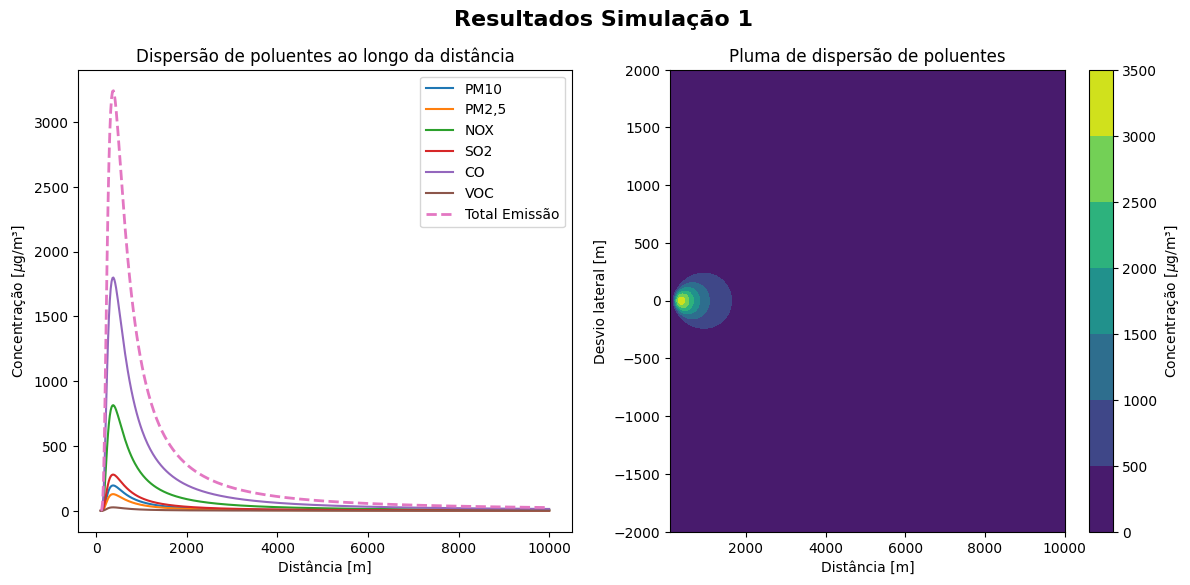

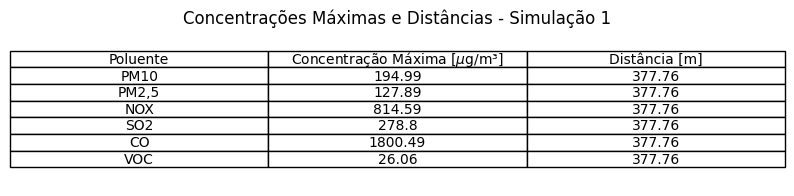


Resultados Simulação 2
Classe de Estabilidade: D


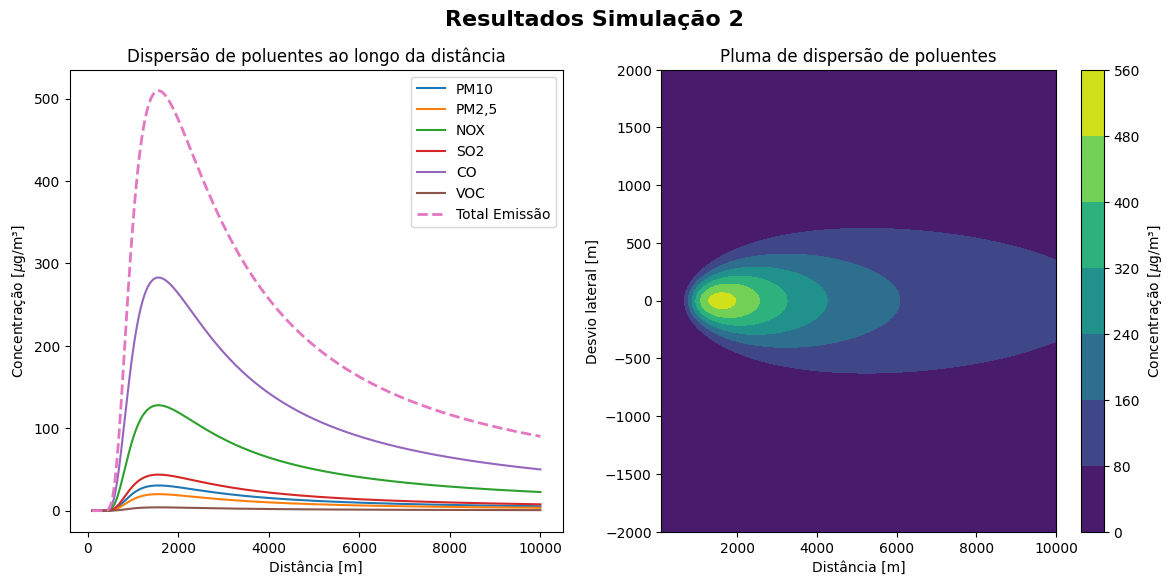

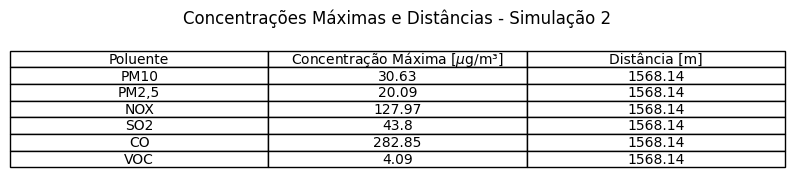

In [83]:
# Parâmetros de entrada para as duas simulações
simulacoes = [
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 100,  # m
        'urbOrRural': 'urbano',
        'd': 3.5,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    },
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 250,  # m
        'urbOrRural': 'urbano',
        'd': 3.0,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    }
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação para cada conjunto de parâmetros
for idx, params in enumerate(simulacoes):
    row = medias_diarias.sample(1).iloc[0]
    classe = row['classe_estabilidade']
    velocidade_vento = row['wind speed (m/s)']
    fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
    cobertura_nuvens = row['cloud cover (tenths)']
    
    print(f"\n{'='*40}\nResultados Simulação {idx+1}\n{'='*40}")
    print(f"Classe de Estabilidade: {classe}")
    
    sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
    deltaH = sobrelevacaoBriggs(params['Fb'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], params['H'], classe)
    H_eff = params['H'] + deltaH
    
    # Criar figura e eixos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Resultados Simulação {idx+1}', fontsize=16, fontweight='bold')
    
    # Inicializar lista para armazenar os dados de concentração máxima
    max_concentrations = []

    # Plotar gráfico de linha para cada poluente e a somatória
    for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
        qs = valor  # Usar o valor do poluente atual
        conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
        ax1.plot(params['x'], conc, label=f'{poluente}')
        
        # Encontrar concentração máxima e distância
        max_conc = np.max(conc)
        max_dist = params['x'][np.argmax(conc)]
        max_concentrations.append((poluente, max_conc, max_dist))

    # Plotar a somatória das emissões
    total_qs = poluentes_df['total_qs'].iloc[0]
    conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)
    
    ax1.set_xlabel('Distância [m]')
    ax1.set_ylabel('Concentração [$\mu$g/m³]')
    ax1.set_title('Dispersão de poluentes ao longo da distância')
    ax1.legend()
    
    # Gráfico de contorno para a somatória das emissões
    X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
    sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
    conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)
    
    contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
    fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
    ax2.set_xlabel('Distância [m]')
    ax2.set_ylabel('Desvio lateral [m]')
    ax2.set_title('Pluma de dispersão de poluentes')
    
    plt.show()
    
    # Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
    max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
    max_conc_df = max_conc_df.round(2)
    
    # Plotar a tabela de concentrações máximas
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
    plt.title(f'Concentrações Máximas e Distâncias - Simulação {idx+1}')
    plt.show()


## Para se adequar à CONAMA 491


Resultados Simulação 1
Classe de Estabilidade: C


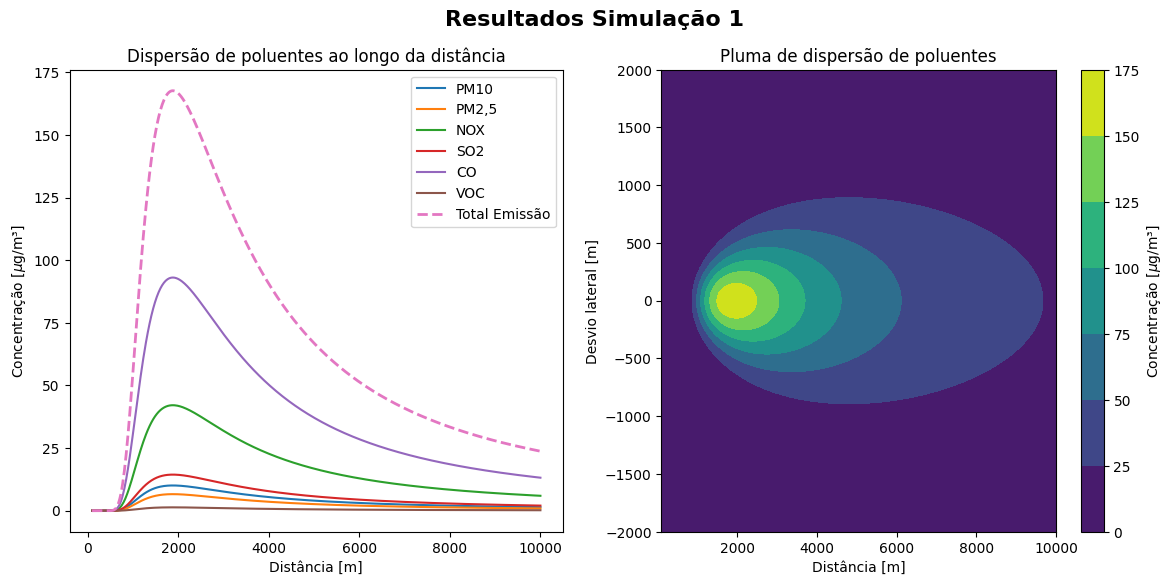

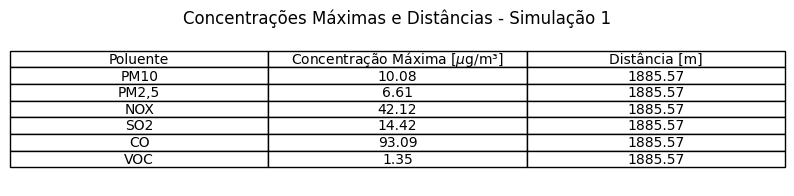

In [85]:
# Parâmetros de entrada para as duas simulações
simulacoes = [
    {
        'u': 5,  # m/s
        'y': 0,  # estimando na direção do vento
        'z': 1.5,  # altura do nariz
        'H': 500,  # m
        'urbOrRural': 'urbano',
        'd': 3.0,  # Diâmetro da chaminé
        'Vs': 20,  # Velocidade de saída do gás
        'p': 1013,  # Pressão atmosférica em hPa
        'deltaT': 60,  # Diferença de temperatura entre a pluma e o ambiente
        'Ts': 533,  # Temperatura de saída da pluma
        'Fb': 1000,  # Fluxo de empuxo da pluma
        'x': np.linspace(100, 10000, 500)  # Distância
    }
]

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação para cada conjunto de parâmetros
for idx, params in enumerate(simulacoes):
    row = medias_diarias.sample(1).iloc[0]
    classe = row['classe_estabilidade']
    velocidade_vento = row['wind speed (m/s)']
    fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
    cobertura_nuvens = row['cloud cover (tenths)']
    
    print(f"\n{'='*40}\nResultados Simulação {idx+1}\n{'='*40}")
    print(f"Classe de Estabilidade: {classe}")
    
    sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
    deltaH = sobrelevacaoBriggs(params['Fb'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], params['H'], classe)
    H_eff = params['H'] + deltaH
    
    # Criar figura e eixos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Resultados Simulação {idx+1}', fontsize=16, fontweight='bold')
    
    # Inicializar lista para armazenar os dados de concentração máxima
    max_concentrations = []

    # Plotar gráfico de linha para cada poluente e a somatória
    for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
        qs = valor  # Usar o valor do poluente atual
        conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
        ax1.plot(params['x'], conc, label=f'{poluente}')
        
        # Encontrar concentração máxima e distância
        max_conc = np.max(conc)
        max_dist = params['x'][np.argmax(conc)]
        max_concentrations.append((poluente, max_conc, max_dist))

    # Plotar a somatória das emissões
    total_qs = poluentes_df['total_qs'].iloc[0]
    conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)
    
    ax1.set_xlabel('Distância [m]')
    ax1.set_ylabel('Concentração [$\mu$g/m³]')
    ax1.set_title('Dispersão de poluentes ao longo da distância')
    ax1.legend()
    
    # Gráfico de contorno para a somatória das emissões
    X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
    sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
    conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)
    
    contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
    fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
    ax2.set_xlabel('Distância [m]')
    ax2.set_ylabel('Desvio lateral [m]')
    ax2.set_title('Pluma de dispersão de poluentes')
    
    plt.show()
    
    # Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
    max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
    max_conc_df = max_conc_df.round(2)
    
    # Plotar a tabela de concentrações máximas
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
    plt.title(f'Concentrações Máximas e Distâncias - Simulação {idx+1}')
    plt.show()
